## U-Net Semantic Segmentation
### by Jason Ohanaga

# Import Libraries

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive

import os
import pandas as pd
import random

import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

# Download Data

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!rsync --info=progress2 -a /content/gdrive/Shareddrives/KAG/kaggle.json kaggle.json

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c carvana-image-masking-challenge
!mkdir input
!mkdir target
!unzip train_hq.zip -d input
!unzip train_masks.zip -d target

             68 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=0/1)
  0% 0.00/107k [00:00<?, ?B/s]
100% 107k/107k [00:00<00:00, 41.2MB/s]
 79% 12.2G/15.4G [02:25<00:31, 110MB/s] 

# Convert to Pandas DF

In [ ]:
inputs_list = sorted(os.listdir("input/train_hq"))
targets_list = sorted(os.listdir("target/train_masks"))

print(len(inputs_list), len(targets_list))

inputs_list = ['input/train_hq/'+filename for filename in inputs_list]
targets_list = ['target/train_masks/'+filename for filename in targets_list]

d = {"input": inputs_list, "target": targets_list}
df = pd.DataFrame(d)
df

5088 5088


input                                       target
0     input/train_hq/00087a6bd4dc_01.jpg  target/train_masks/00087a6bd4dc_01_mask.gif
1     input/train_hq/00087a6bd4dc_02.jpg  target/train_masks/00087a6bd4dc_02_mask.gif
2     input/train_hq/00087a6bd4dc_03.jpg  target/train_masks/00087a6bd4dc_03_mask.gif
3     input/train_hq/00087a6bd4dc_04.jpg  target/train_masks/00087a6bd4dc_04_mask.gif
4     input/train_hq/00087a6bd4dc_05.jpg  target/train_masks/00087a6bd4dc_05_mask.gif
...                                  ...                                          ...
5083  input/train_hq/fff9b3a5373f_12.jpg  target/train_masks/fff9b3a5373f_12_mask.gif
5084  input/train_hq/fff9b3a5373f_13.jpg  target/train_masks/fff9b3a5373f_13_mask.gif
5085  input/train_hq/fff9b3a5373f_14.jpg  target/train_masks/fff9b3a5373f_14_mask.gif
5086  input/train_hq/fff9b3a5373f_15.jpg  target/train_masks/fff9b3a5373f_15_mask.gif
5087  input/train_hq/fff9b3a5373f_16.jpg  target/train_masks/fff9b3a5373f_16_mask.gif

[5088 rows x 2 columns]

# Visualize Dataset

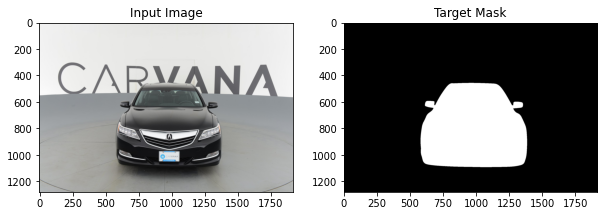

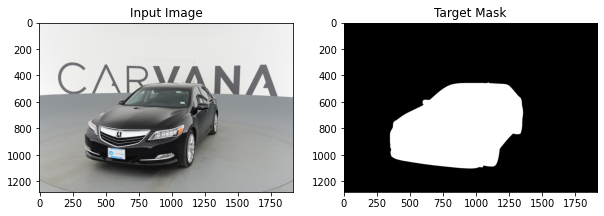

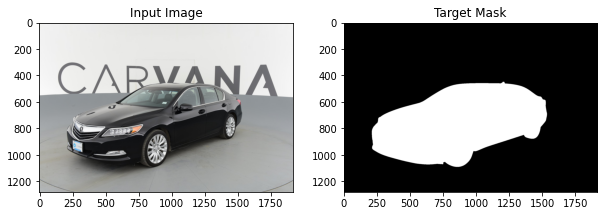

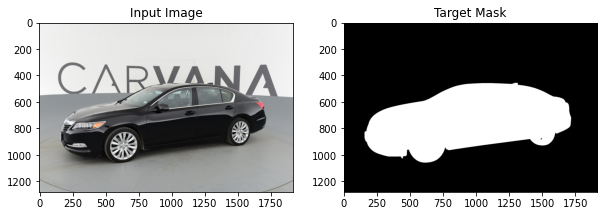

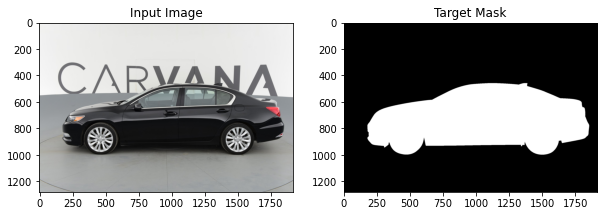

In [ ]:
# visualize dataset
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'Target Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    img = mpimg.imread(display_list[i])
    plt.imshow(img)
    plt.axis('on')
  plt.show()

count = 0
for image, mask in zip(df['input'], df['target']):
  if count == 5:
    break
  count += 1
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])


# Preprocess Dataset

In [ ]:
# preprocess

# image size needs to be divisble by 32
IMG_SIZE = 512

def normalize(image, mask):
  image = tf.cast(image, tf.float32)
  image = tf.keras.applications.resnet_v2.preprocess_input(image) #resnet -1 -> 1
  mask = mask[:,:,:1] # predictions are going to be channel 1 so convert mask to channel 1 as well
  mask = tf.math.sign(mask) # mask pixel either 0 or 1 instead of 0 or 255
  return image, mask

def prepare_train(dataset):
  # decode
  image = tf.image.decode_jpeg(tf.io.read_file(dataset['input']), channels=3)
  mask = tf.image.decode_jpeg(tf.io.read_file(dataset['target']), channels=3)

  # resize
  image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
  mask = tf.image.resize(mask, (IMG_SIZE,IMG_SIZE))

  # randomly flip image and mask
  if tf.random.uniform(()) > .5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

  # normalize image and its mask
  image, mask = normalize(image, mask)
  return image, mask

def prepare_test(dataset):
  # decode
  image = tf.image.decode_jpeg(tf.io.read_file(dataset['input']), channels=3)
  mask = tf.image.decode_jpeg(tf.io.read_file(dataset['target']), channels=3)

  # resize
  image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
  mask = tf.image.resize(mask, (IMG_SIZE,IMG_SIZE))
  
  image, mask = normalize(image, mask)
  return image, mask


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['input'], df['target'], random_state=42, test_size=0.18, shuffle=False)

train_ds = pd.DataFrame({'input': x_train, 'target': y_train})
test_ds = pd.DataFrame({'input': x_test, 'target': y_test})

train_ds
test_ds

TRAIN_LENGTH = len(train_ds)
TEST_LENGTH = len(test_ds)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# create and train and test generator
train = tf.data.Dataset.from_tensor_slices({'input': train_ds['input'], 'target': train_ds['target']})
train = train.map(prepare_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # only suffle for training dataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test = tf.data.Dataset.from_tensor_slices({'input': test_ds['input'], 'target': test_ds['target']})
test = test.map(prepare_test)
test_dataset = test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

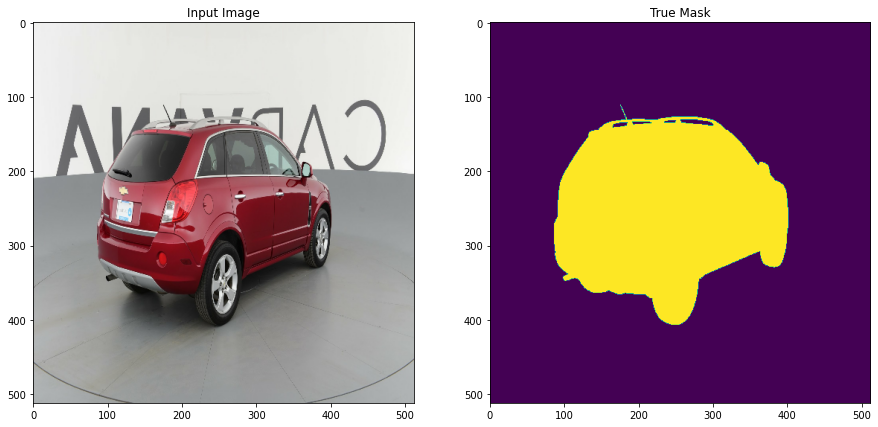

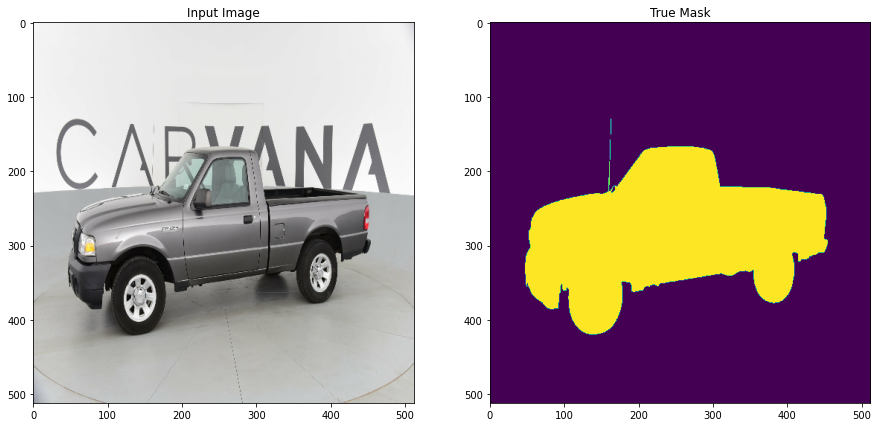

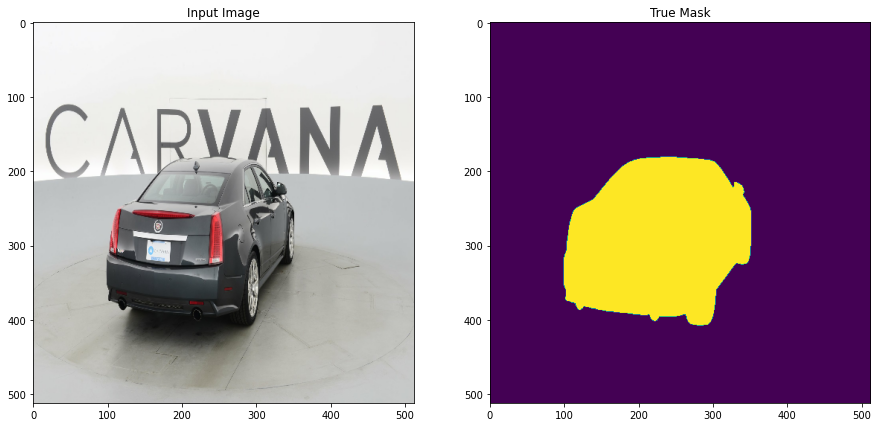

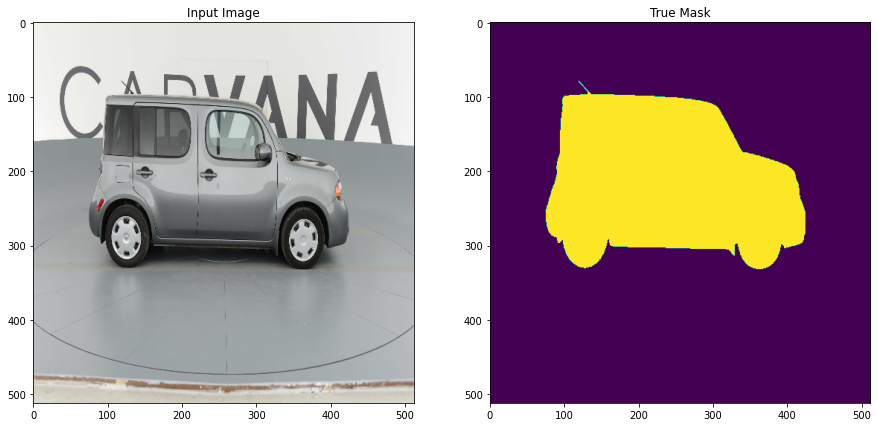

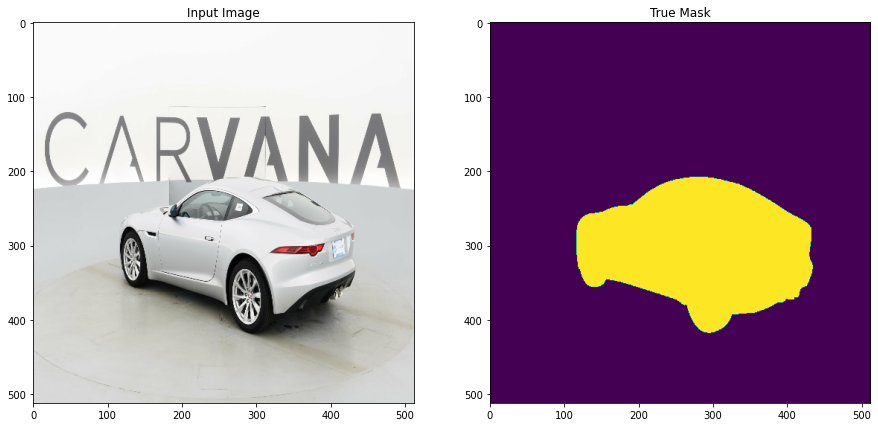

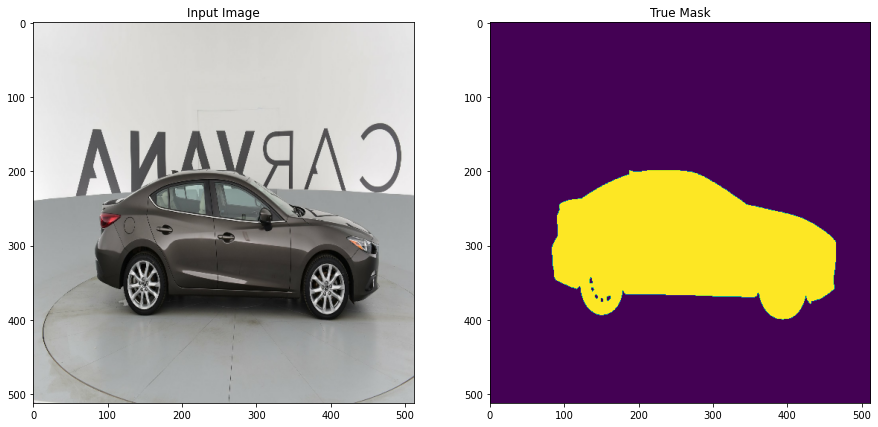

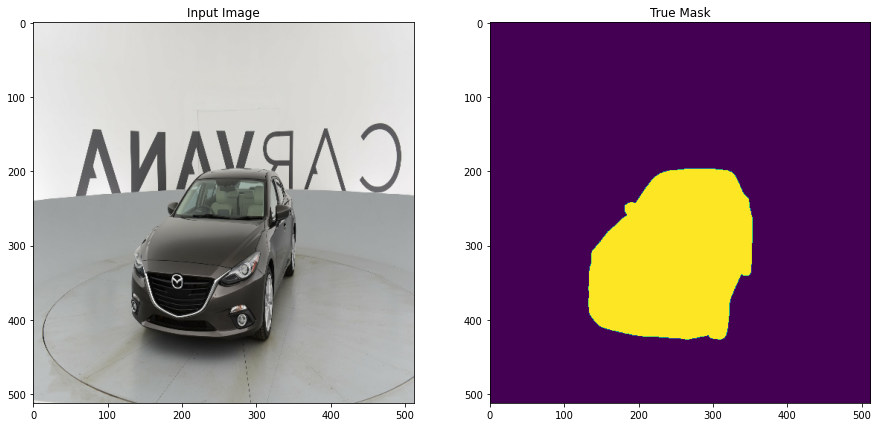

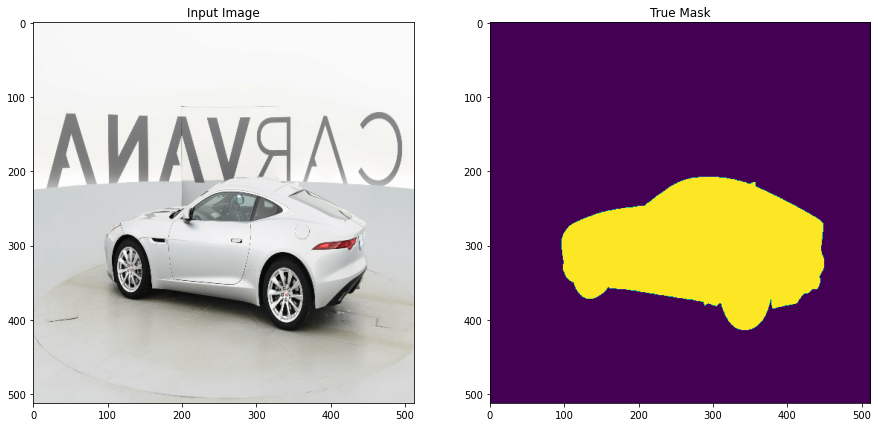

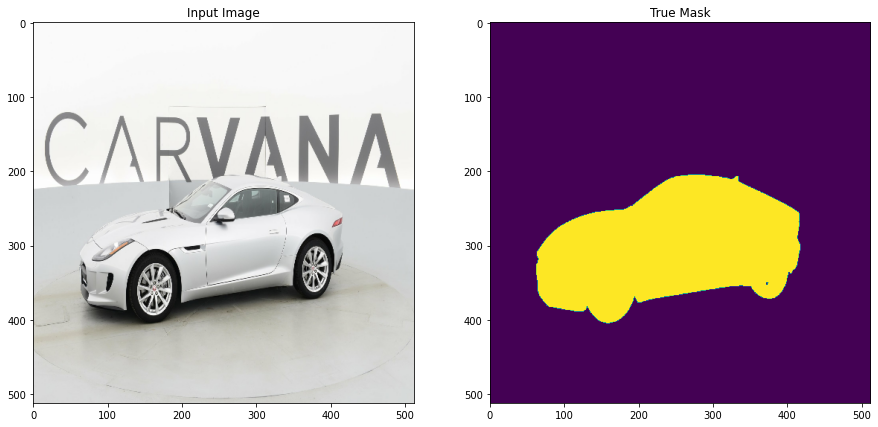

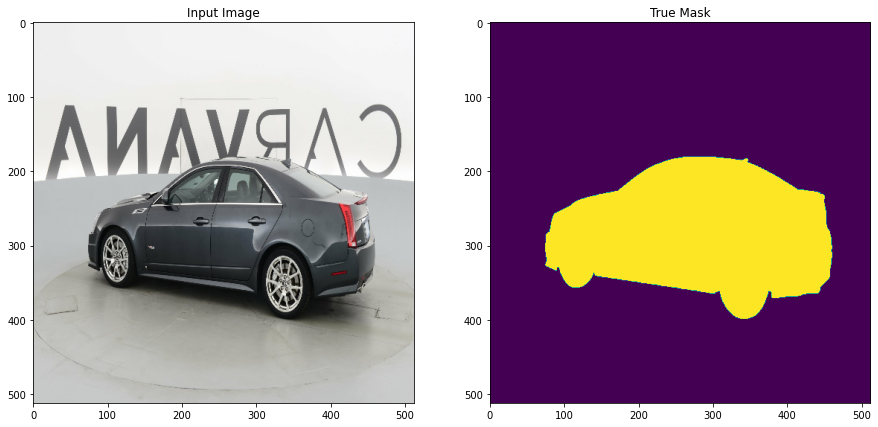

In [ ]:
# visualize dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Edit']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) #converts from arr to PIL image then displayed
    plt.axis('on')
  plt.show()

for i in range(10):
  rand = random.randint(0,100)
  for image, mask in train.take(rand): # take from train and not train dataset because train doesn't have batch included
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

# Create model

In [ ]:
NUM_CLASSES = 1
base_model = tf.keras.applications.ResNet152V2(input_shape=[IMG_SIZE,IMG_SIZE,3], include_top=False, weights='imagenet')
# base_model.summary()

234553344/234545216 [==============================] - 2s 0us/step


In [ ]:
# get outputs of these layers
layer_names = [
  'conv1_conv',
  'conv2_block3_1_relu',
  'conv3_block8_1_relu',
  'conv4_block36_1_relu',
  'post_bn',
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [ ]:
def upsample(filters, size, strides=2, dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=strides, padding='same', 
                                            kernel_initializer=initializer, use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  if dropout:
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.ReLU())
  return model

up_stack = [
  upsample(512, 3), # 16x16 -> 32x32
  upsample(256, 3), # 32x32 -> 64x64
  upsample(128, 3), # 64x64 -> 128x128
  upsample(64, 3),  # 128x128 -> 512x512
]

In [ ]:
# functional API: output of prev layer becomes input of next layer
def unet_model():
  inputs = tf.keras.layers.Input(shape=[IMG_SIZE,IMG_SIZE,3])

  # downsample
  skips = down_stack(inputs)
  x = skips[-1] # last ouput from pretrained model which is 4x4
  skips = reversed(skips[:-1]) # reverse the list of outputs excluding the last output layer

  # upsampling
  for upsample, skip in zip(up_stack, skips):
    x = upsample(x) # 4x4 -> 8x8 -> 16x16 ... etc
    x = tf.keras.layers.Concatenate()([x, skip]) # 8x8 (upsample) + 8x8 (downsample) + 16x16 (upsample) + 16x16 (downsample) ... etc.
  
  # final layer: 64x64 -> 128x128 (input size) into 3 different classes
  output = tf.keras.layers.Conv2DTranspose(NUM_CLASSES, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x)

  return tf.keras.Model(inputs=inputs, outputs=output)

# Define Metrics

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=bce_dice_loss,
              metrics=[dice_coef, 'binary_accuracy'])

# print(model.summary())
# tf.keras.utils.plot_model(model, show_shapes=True)

# Redefine Visualization Functions

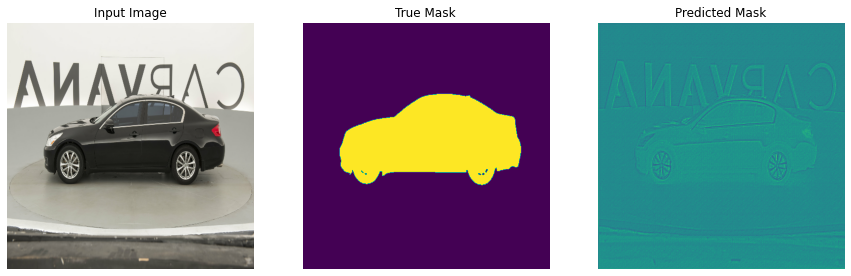

In [ ]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

# redefine display function to account for img being in array format  
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) 
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image) # batch dimension already added from generator
      display([image[0], mask[0], pred_mask[0]]) # shape is 32 (batch), img_size, img_size, 1 so take first image from that batch
  else:
    pred_mask = model.predict(sample_image[tf.newaxis, ...]) #tf.newaxis is to add batch dimension which is necessary for the model
    pred_mask = pred_mask.reshape(pred_mask.shape[1],pred_mask.shape[2],1)
    display([sample_image, sample_mask, pred_mask])
    
show_predictions()

# Train Model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# visualization callback and early stopping callback
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/25
130/130 [==============================] - 158s 997ms/step - loss: 0.2456 - dice_coef: 0.9532 - binary_accuracy: 0.9789 - val_loss: 0.0914 - val_dice_coef: 0.9792 - val_binary_accuracy: 0.9911


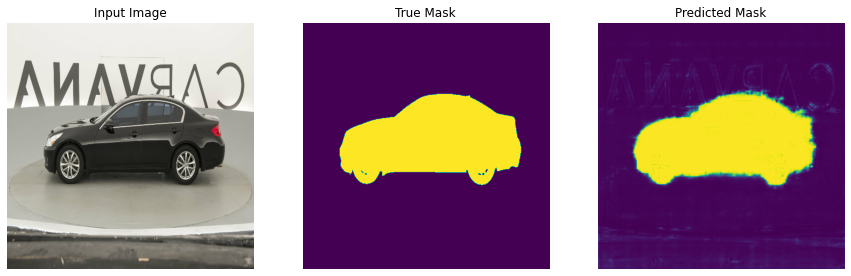


Sample Prediction after epoch 1

Epoch 2/25
130/130 [==============================] - 123s 942ms/step - loss: 0.0494 - dice_coef: 0.9846 - binary_accuracy: 0.9935 - val_loss: 0.0611 - val_dice_coef: 0.9828 - val_binary_accuracy: 0.9928


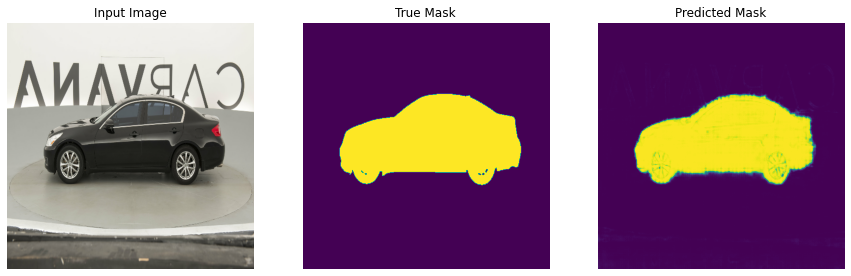


Sample Prediction after epoch 2

Epoch 3/25
130/130 [==============================] - 122s 938ms/step - loss: 0.0349 - dice_coef: 0.9876 - binary_accuracy: 0.9948 - val_loss: 0.0449 - val_dice_coef: 0.9861 - val_binary_accuracy: 0.9941


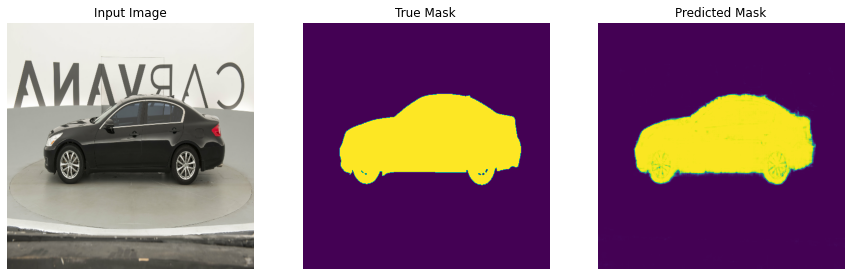


Sample Prediction after epoch 3

Epoch 4/25
130/130 [==============================] - 122s 939ms/step - loss: 0.0290 - dice_coef: 0.9891 - binary_accuracy: 0.9954 - val_loss: 0.0340 - val_dice_coef: 0.9881 - val_binary_accuracy: 0.9950


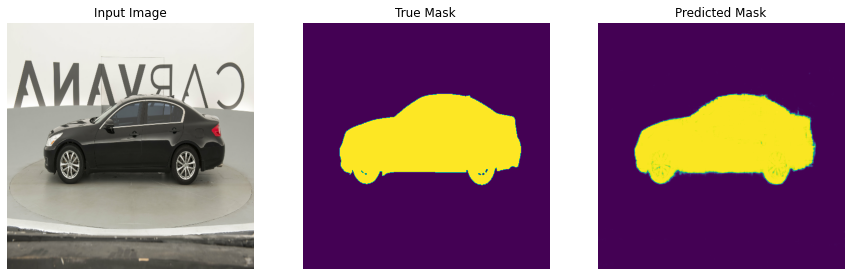


Sample Prediction after epoch 4

Epoch 5/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0264 - dice_coef: 0.9898 - binary_accuracy: 0.9957 - val_loss: 0.0288 - val_dice_coef: 0.9889 - val_binary_accuracy: 0.9953


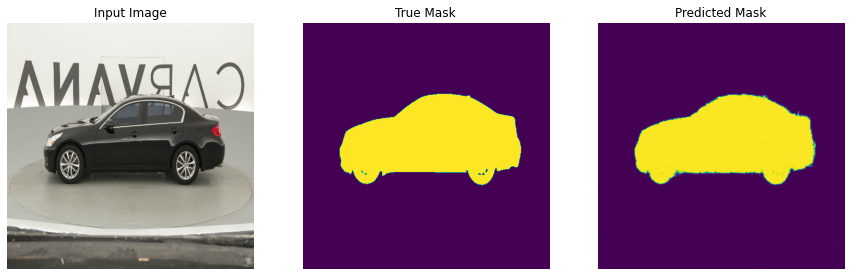


Sample Prediction after epoch 5

Epoch 6/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0243 - dice_coef: 0.9904 - binary_accuracy: 0.9959 - val_loss: 0.0267 - val_dice_coef: 0.9895 - val_binary_accuracy: 0.9956


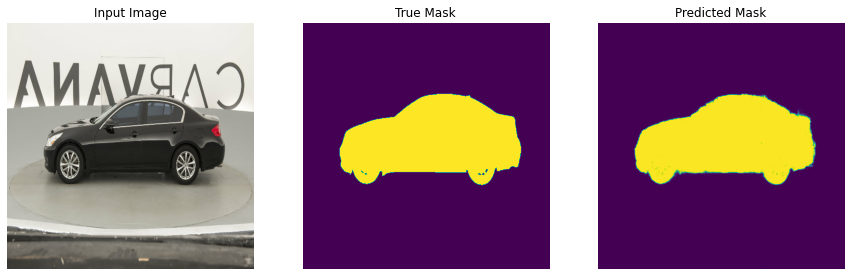


Sample Prediction after epoch 6

Epoch 7/25
130/130 [==============================] - 122s 941ms/step - loss: 0.0227 - dice_coef: 0.9910 - binary_accuracy: 0.9962 - val_loss: 0.0237 - val_dice_coef: 0.9906 - val_binary_accuracy: 0.9960


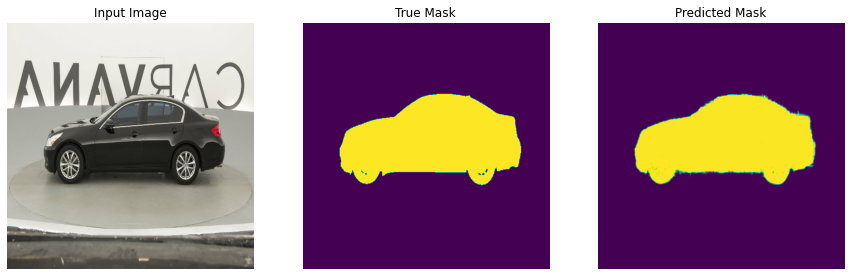


Sample Prediction after epoch 7

Epoch 8/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0214 - dice_coef: 0.9914 - binary_accuracy: 0.9964 - val_loss: 0.0227 - val_dice_coef: 0.9907 - val_binary_accuracy: 0.9961


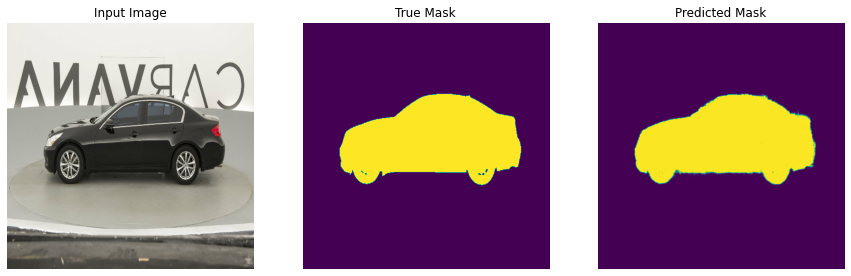


Sample Prediction after epoch 8

Epoch 9/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0205 - dice_coef: 0.9917 - binary_accuracy: 0.9965 - val_loss: 0.0218 - val_dice_coef: 0.9911 - val_binary_accuracy: 0.9963


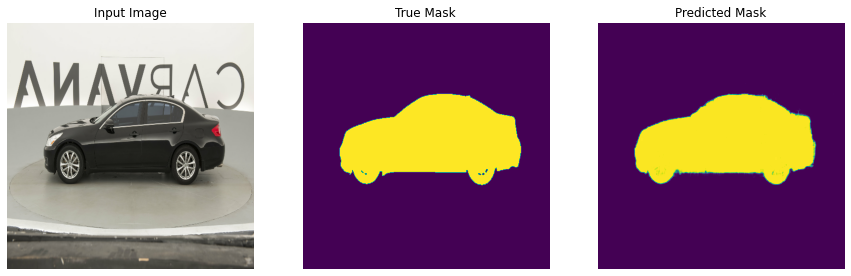


Sample Prediction after epoch 9

Epoch 10/25
130/130 [==============================] - 122s 939ms/step - loss: 0.0195 - dice_coef: 0.9921 - binary_accuracy: 0.9967 - val_loss: 0.0202 - val_dice_coef: 0.9917 - val_binary_accuracy: 0.9965


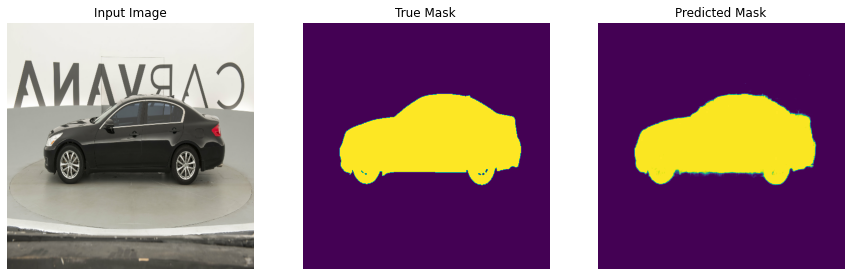


Sample Prediction after epoch 10

Epoch 11/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0189 - dice_coef: 0.9923 - binary_accuracy: 0.9967 - val_loss: 0.0202 - val_dice_coef: 0.9917 - val_binary_accuracy: 0.9965


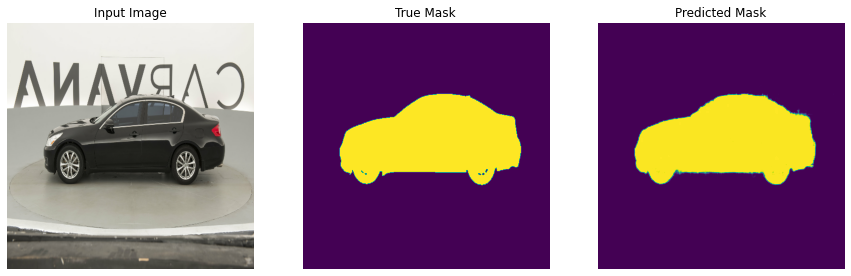


Sample Prediction after epoch 11

Epoch 12/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0181 - dice_coef: 0.9926 - binary_accuracy: 0.9969 - val_loss: 0.0198 - val_dice_coef: 0.9918 - val_binary_accuracy: 0.9966


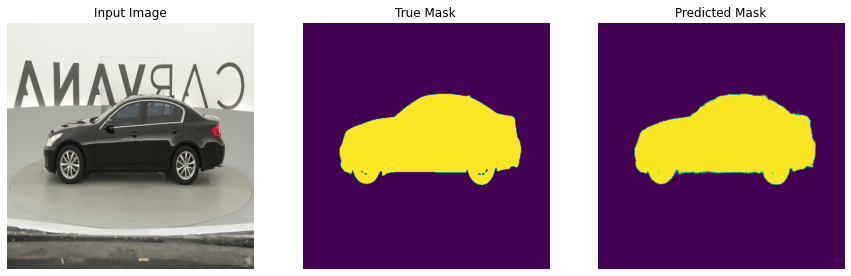


Sample Prediction after epoch 12

Epoch 13/25
130/130 [==============================] - 122s 939ms/step - loss: 0.0175 - dice_coef: 0.9928 - binary_accuracy: 0.9970 - val_loss: 0.0199 - val_dice_coef: 0.9917 - val_binary_accuracy: 0.9965


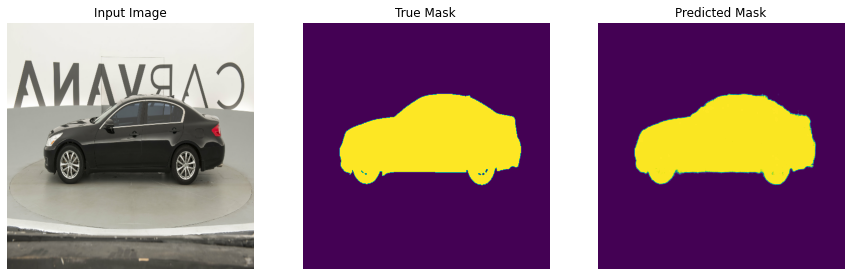


Sample Prediction after epoch 13

Epoch 14/25
130/130 [==============================] - 122s 941ms/step - loss: 0.0170 - dice_coef: 0.9930 - binary_accuracy: 0.9970 - val_loss: 0.0199 - val_dice_coef: 0.9917 - val_binary_accuracy: 0.9965


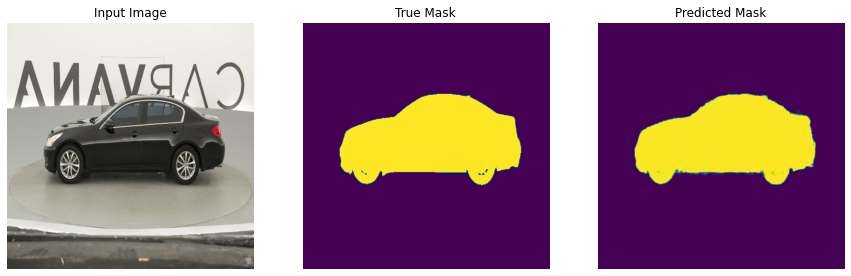


Sample Prediction after epoch 14

Epoch 15/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0163 - dice_coef: 0.9933 - binary_accuracy: 0.9971 - val_loss: 0.0191 - val_dice_coef: 0.9921 - val_binary_accuracy: 0.9966


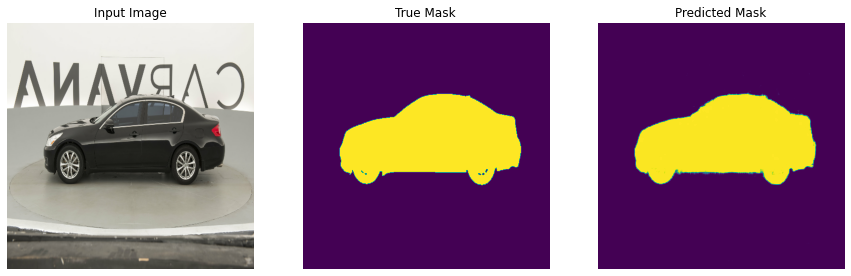


Sample Prediction after epoch 15

Epoch 16/25
130/130 [==============================] - 122s 941ms/step - loss: 0.0160 - dice_coef: 0.9934 - binary_accuracy: 0.9972 - val_loss: 0.0188 - val_dice_coef: 0.9922 - val_binary_accuracy: 0.9967


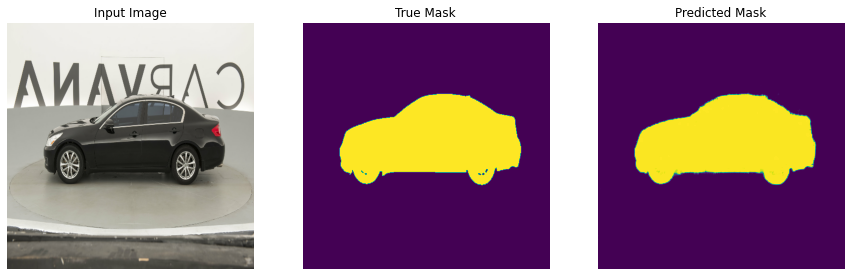


Sample Prediction after epoch 16

Epoch 17/25
130/130 [==============================] - 122s 942ms/step - loss: 0.0155 - dice_coef: 0.9936 - binary_accuracy: 0.9973 - val_loss: 0.0194 - val_dice_coef: 0.9919 - val_binary_accuracy: 0.9966


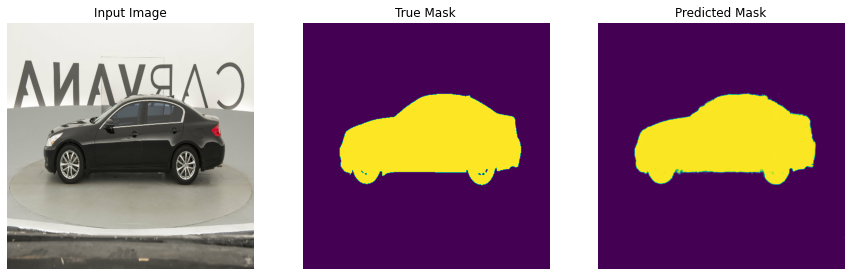


Sample Prediction after epoch 17

Epoch 18/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0152 - dice_coef: 0.9937 - binary_accuracy: 0.9973 - val_loss: 0.0186 - val_dice_coef: 0.9923 - val_binary_accuracy: 0.9967


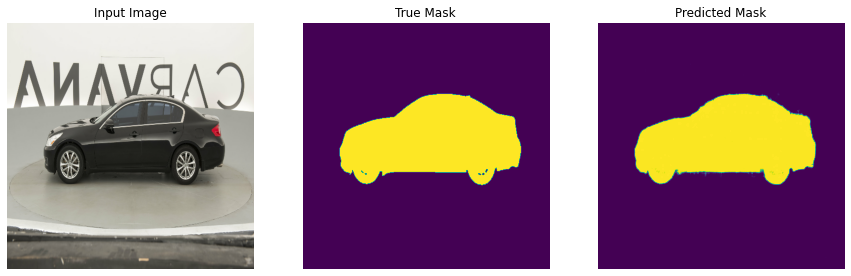


Sample Prediction after epoch 18

Epoch 19/25
130/130 [==============================] - 122s 941ms/step - loss: 0.0145 - dice_coef: 0.9940 - binary_accuracy: 0.9975 - val_loss: 0.0185 - val_dice_coef: 0.9923 - val_binary_accuracy: 0.9967


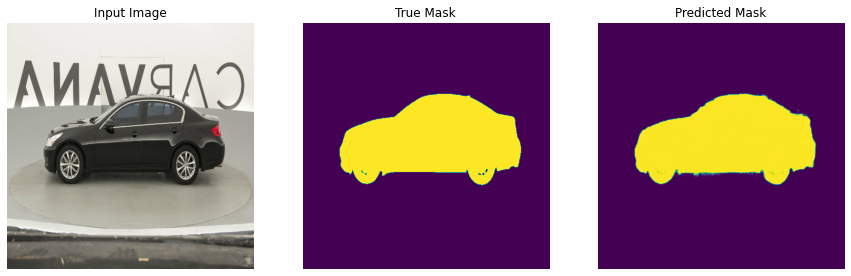


Sample Prediction after epoch 19

Epoch 20/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0142 - dice_coef: 0.9941 - binary_accuracy: 0.9975 - val_loss: 0.0186 - val_dice_coef: 0.9923 - val_binary_accuracy: 0.9967


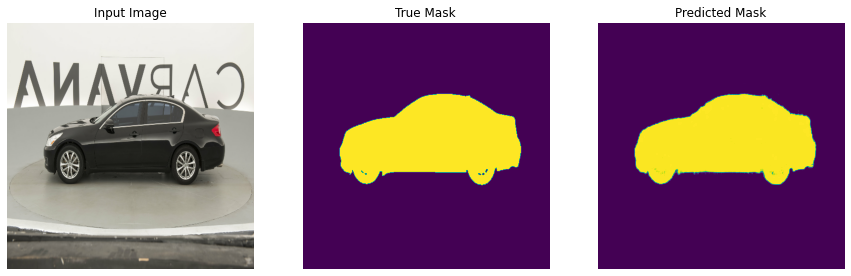


Sample Prediction after epoch 20

Epoch 21/25
130/130 [==============================] - 122s 941ms/step - loss: 0.0137 - dice_coef: 0.9943 - binary_accuracy: 0.9976 - val_loss: 0.0184 - val_dice_coef: 0.9924 - val_binary_accuracy: 0.9968


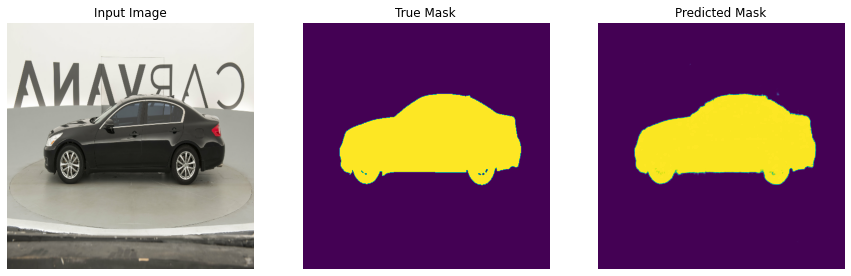


Sample Prediction after epoch 21

Epoch 22/25
130/130 [==============================] - 122s 941ms/step - loss: 0.0136 - dice_coef: 0.9944 - binary_accuracy: 0.9976 - val_loss: 0.0185 - val_dice_coef: 0.9924 - val_binary_accuracy: 0.9968


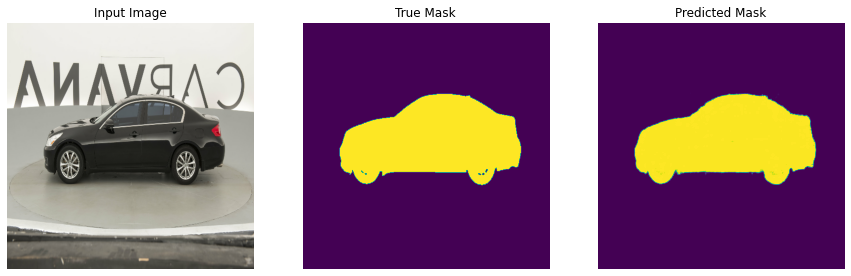


Sample Prediction after epoch 22

Epoch 23/25
130/130 [==============================] - 122s 940ms/step - loss: 0.0129 - dice_coef: 0.9946 - binary_accuracy: 0.9977 - val_loss: 0.0183 - val_dice_coef: 0.9925 - val_binary_accuracy: 0.9968


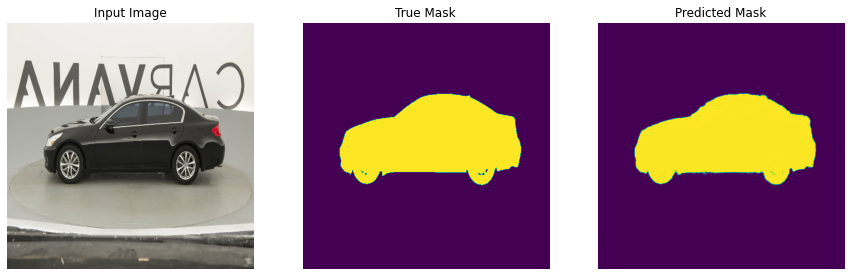


Sample Prediction after epoch 23

Epoch 24/25
130/130 [==============================] - 122s 941ms/step - loss: 0.0127 - dice_coef: 0.9947 - binary_accuracy: 0.9978 - val_loss: 0.0183 - val_dice_coef: 0.9925 - val_binary_accuracy: 0.9968


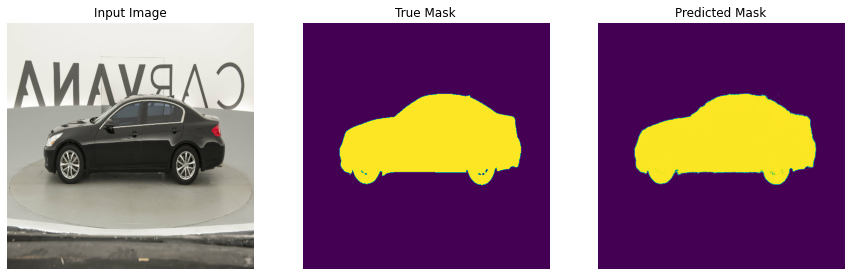


Sample Prediction after epoch 24

Epoch 25/25
130/130 [==============================] - 123s 943ms/step - loss: 0.0122 - dice_coef: 0.9949 - binary_accuracy: 0.9979 - val_loss: 0.0185 - val_dice_coef: 0.9924 - val_binary_accuracy: 0.9968


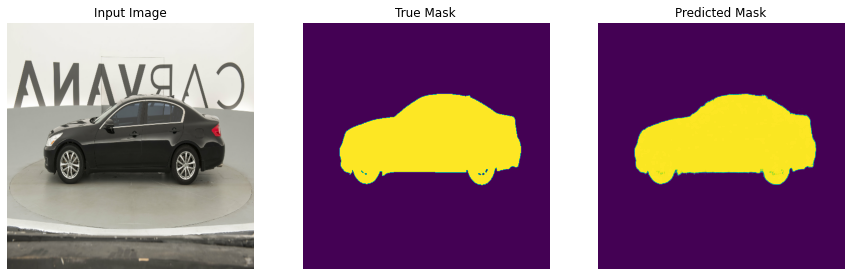


Sample Prediction after epoch 25



In [ ]:
EPOCHS = 25
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 2
VAL_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(train_dataset, 
  epochs=EPOCHS, 
  steps_per_epoch=STEPS_PER_EPOCH, 
  validation_steps=VAL_STEPS, 
  validation_data=test_dataset, 
  callbacks=[DisplayCallback(), early_stop],
)

# Visualize Training

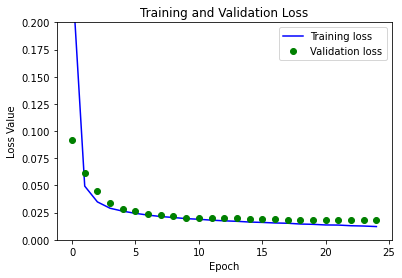

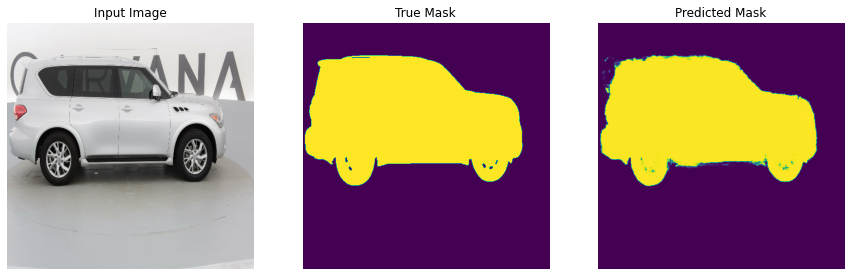

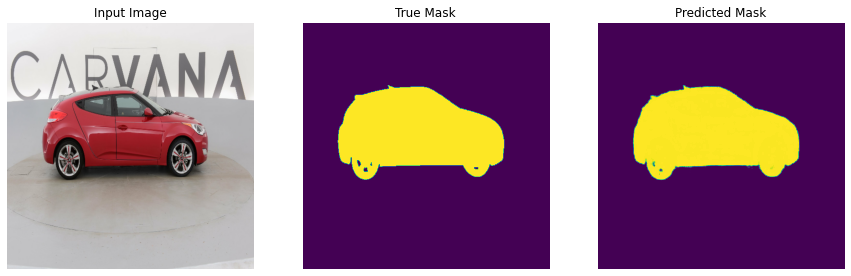

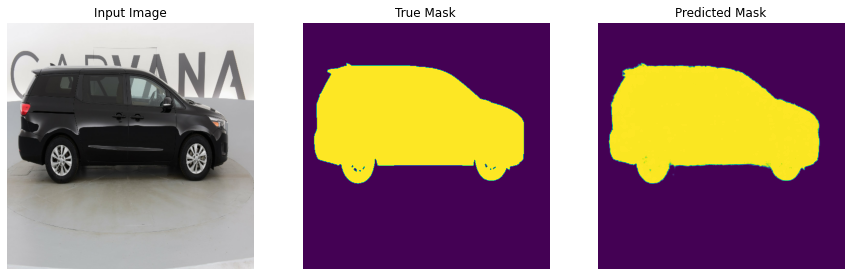

In [ ]:
# visualize training
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'b', label='Training loss')
plt.plot(history.epoch, val_loss, 'go', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, .2])
plt.legend()
plt.show()

show_predictions(test_dataset, 3)

# Evaluate Model

In [ ]:
dice_loss, dice_coef, acc = model.evaluate(test_dataset)
print("This model has an dice coef of: {} \nThis model has a binary accuracy of: {}".format(dice_coef, acc))

29/29 [==============================] - 22s 724ms/step - loss: 0.0207 - dice_coef: 0.9918 - binary_accuracy: 0.9965
This model has an dice coef of: 0.9917827248573303 
This model has a binary accuracy of: 0.9964693784713745


How to improve:
 - use metadata and create specific weights for different types of cars
 - dialate the lr when val loss begins to platau
 - add other data augmentation operations
 - add more dropout and increase num of epochs
 - change kernel initializer